# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

Признаки:

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard`— наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак:

- `Exited` — факт ухода клиента

## Загрузка библиотек и данных

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

In [4]:
data.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9960,9961,15681026,Lucciano,795,Germany,Female,33,9.0,104552.72,1,1,1,120853.83,1
9120,9121,15796838,Chibugo,703,Spain,Male,58,4.0,92930.92,1,0,1,85148.78,0
7793,7794,15798885,Burns,585,France,Male,56,4.0,138227.19,2,1,1,55287.84,0
89,90,15767954,Osborne,635,Germany,Female,28,3.0,81623.67,2,1,1,156791.36,0
667,668,15575024,Uwaezuoke,503,France,Male,29,3.0,0.00,2,1,1,143954.99,0


Подправим названия колонок:

In [5]:
data.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']

Проверка на явные дубликаты:

In [6]:
data.duplicated().sum()

0

Явных дубликатов нет.

Проверка на пропуски и типы данных:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце `tenure` есть пропуски, заменим их медианой. Также заменим тип данных на `int`.

In [9]:
data.loc[data['tenure'].isna(), 'tenure'] = data.tenure.median()

In [11]:
data.tenure.isna().sum()

0

Теперь пропусков нет.

In [12]:
data['tenure'] = data['tenure'].astype('int32')
data['tenure'].dtypes

dtype('int32')

Заменим все 64 разрядные переменные 32-х разрядными.

In [13]:
data[data.select_dtypes(include=['float64']).columns] = data[data.select_dtypes(include=['float64']).columns].astype('float32')
data[data.select_dtypes(include=['int64']).columns] = data[data.select_dtypes(include=['int64']).columns].astype('int32')

Заключительная проверка:

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int32  
 1   customer_id       10000 non-null  int32  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int32  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int32  
 7   tenure            10000 non-null  int32  
 8   balance           10000 non-null  float32
 9   num_of_products   10000 non-null  int32  
 10  has_cr_card       10000 non-null  int32  
 11  is_active_member  10000 non-null  int32  
 12  estimated_salary  10000 non-null  float32
 13  exited            10000 non-null  int32  
dtypes: float32(2), int32(9), object(3)
memory usage: 664.2+ KB


Посмотрим на распределение данных:

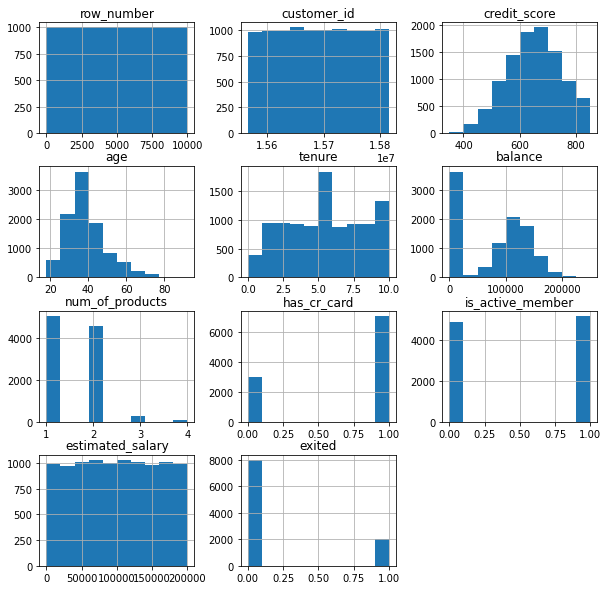

In [14]:
data.hist(figsize=(10,10));

Аномальных выбросов в данных не наблюдается.

Посмотрим есть ли в данных мультиколлениарность:

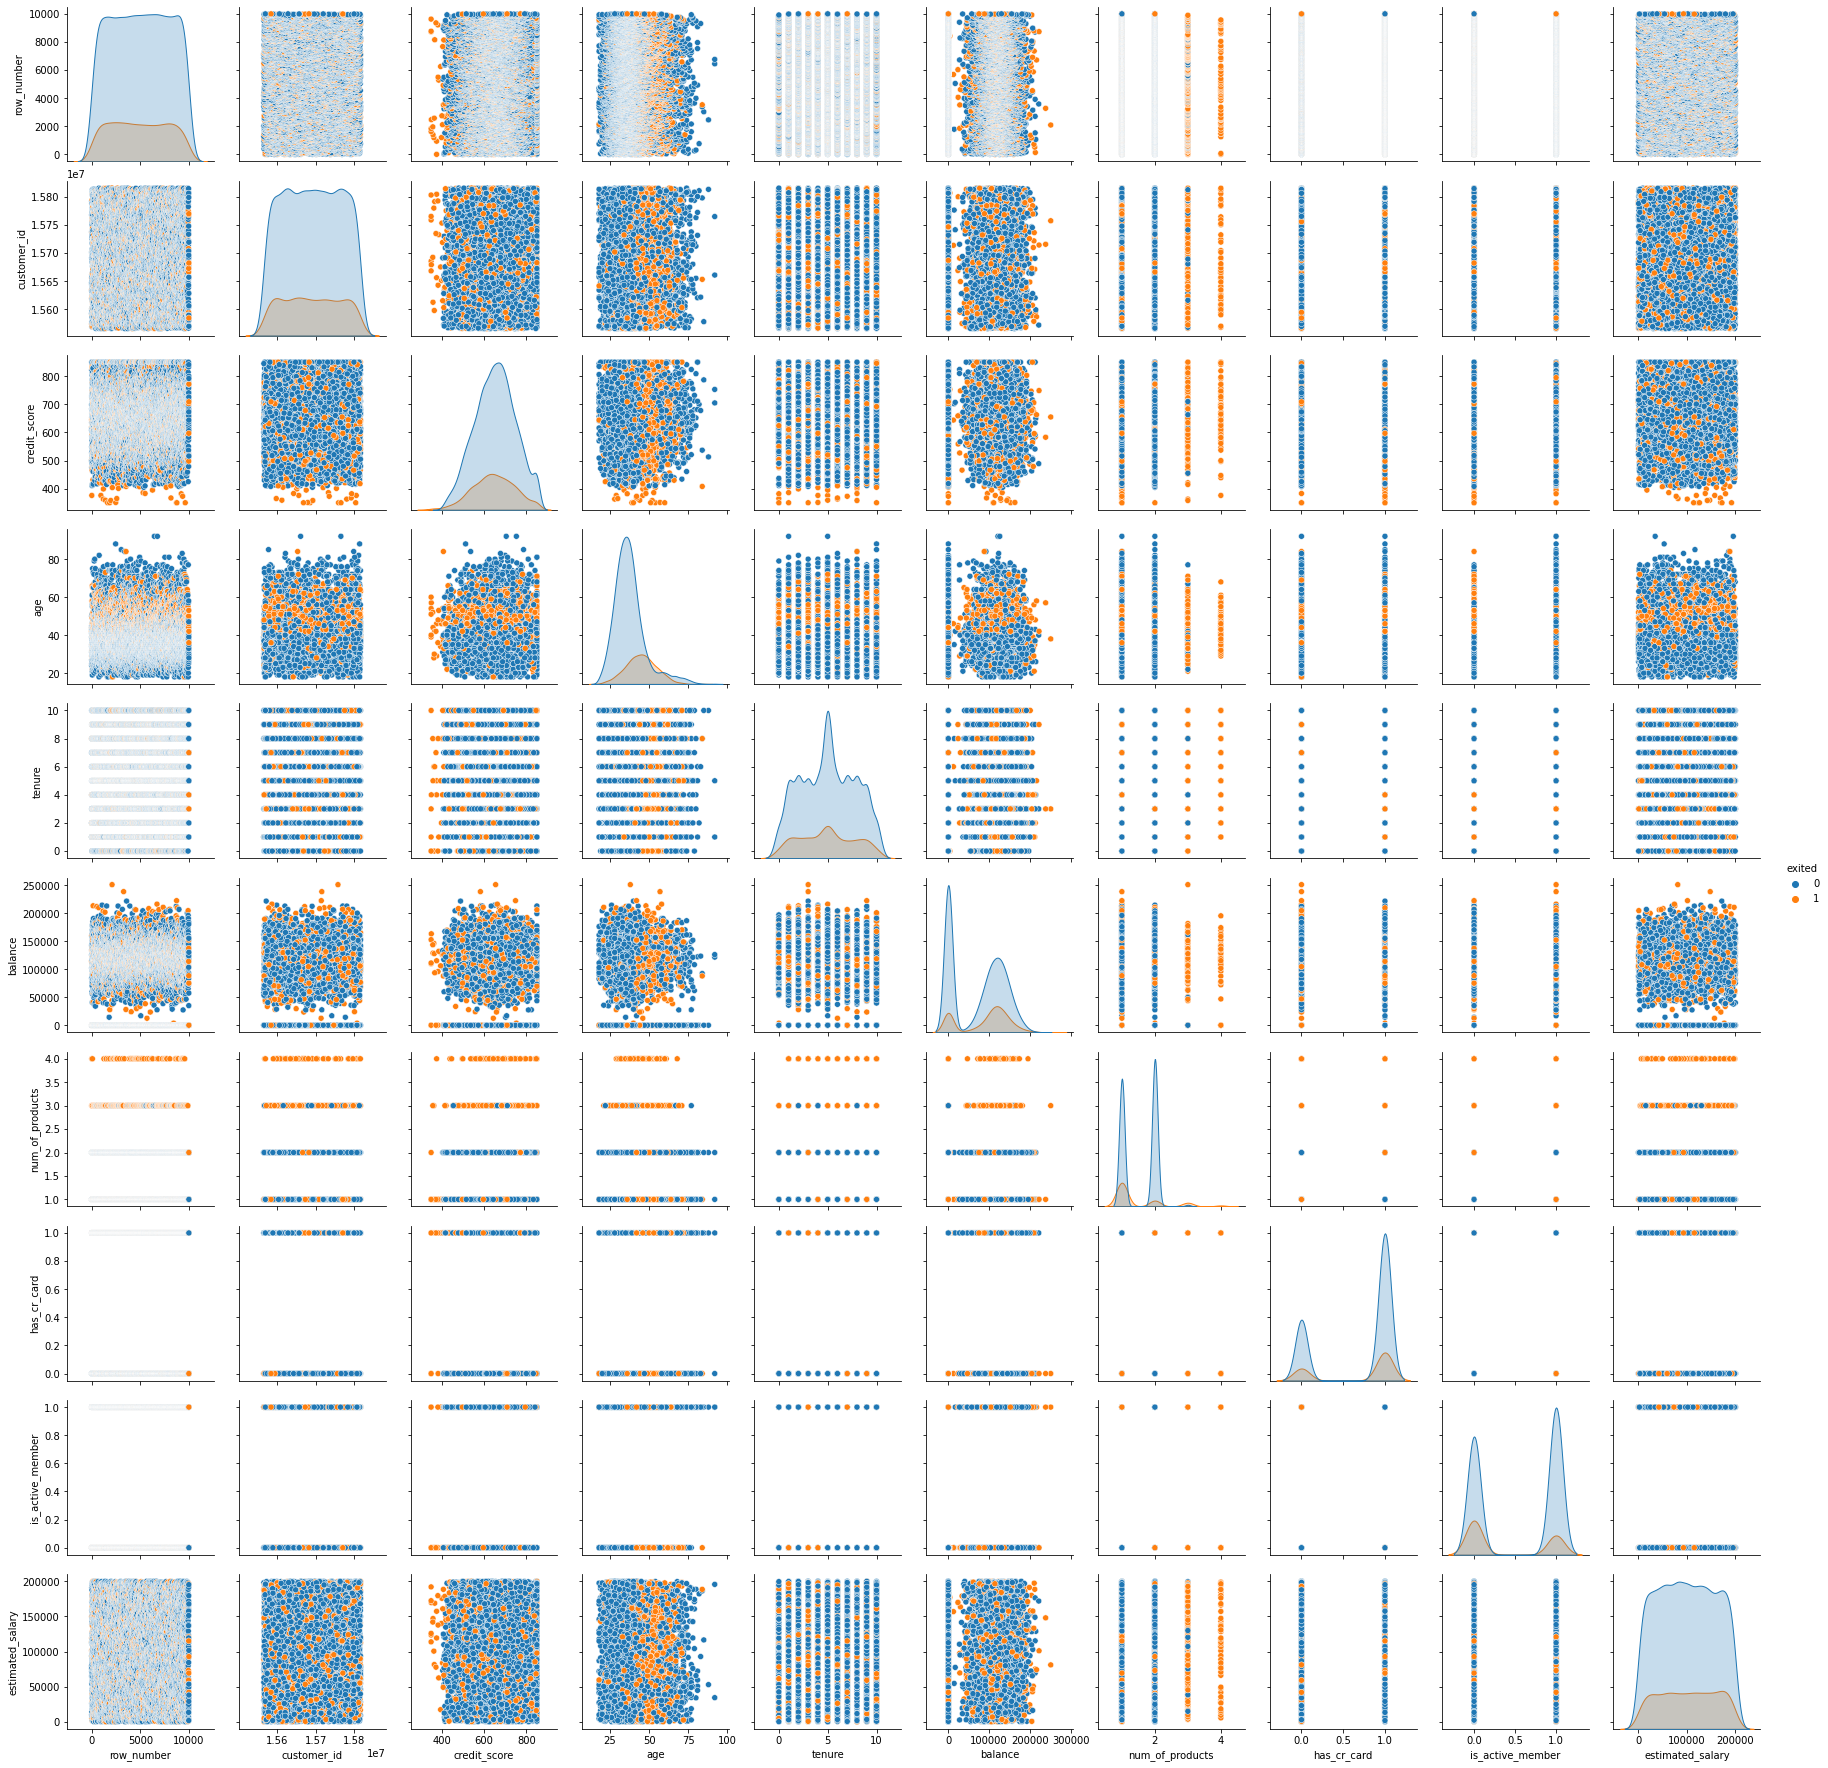

In [16]:
sns.pairplot(data, hue='exited');

Явных линейных зависимостей не обнаружено.

## Исследование задачи

Формируем рабочие признаки:

In [15]:
features = data.loc[:, ('credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary')]
features = pd.get_dummies(features, drop_first=True)
features.sample(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
9581,850,28,9,0.000000,2,1,1,164864.671875,0,0,0
2645,755,23,5,84284.476562,2,1,1,62851.601562,0,0,1
8196,588,30,3,115007.078125,1,0,0,176858.500000,0,0,1
383,709,28,8,124695.718750,2,1,0,145251.343750,1,0,1
9145,712,45,6,112994.648438,1,0,0,198398.687500,0,1,1


Формируем целевой признак:

In [16]:
target = data['exited']
target.sample(5)

4262    0
7374    1
6633    1
2973    1
9892    0
Name: exited, dtype: int32

In [17]:
target.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Наблюдается сильный дисбаланс классов с перекосом в сторону нулевого. На данном этапе оставим как есть и посмотрим как модель работает с несбалансированными данным.

Разбиваем данные на обучающую, валидационную и тестовую выборки.

In [18]:
features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(features, target, 
                                                                              test_size=0.3, random_state=0)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_and_test, target_valid_and_test,
                                                                            test_size=0.333, random_state=0)
print(f'В обучающей выборке {len(features_train)/len(features):.1%} данных')
print(f'В валидационной выборке {len(features_valid)/len(features):.1%} данных')
print(f'В тестовой выборке {len(features_test)/len(features):.1%} данных')

В обучающей выборке 70.0% данных
В валидационной выборке 20.0% данных
В тестовой выборке 10.0% данных


Стандартизуем признаки:

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(features_train)

features_train = pd.DataFrame(scaler.transform(features_train))
features_valid = pd.DataFrame(scaler.transform(features_valid))
features_test = pd.DataFrame(scaler.transform(features_test))

target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

features_train.columns = features.columns
features_valid.columns = features.columns
features_test.columns = features.columns

### Построение модели

Объявим функцию для нахождения лучших значений гиперматаметров различных моделей. Она возвращает выбранную модель с лучшими гиперпараметрами.

In [20]:
def find_best_model(model, features_train=features_train, target_train=target_train,
                    features_valid=features_valid, target_valid=target_valid,
                    max_depth=10, n_estimators=10,  max_iter=10, step=1, solver='lbfgs',
                    class_weight=None):
    
    if model == 'tree':
        f1_tree_best = 0
        for depth in range(1, max_depth, step):
            dt = DecisionTreeClassifier(random_state=0, max_depth=depth, class_weight=class_weight)
            dt.fit(features_train, target_train)
            predicted = dt.predict(features_valid)
            if f1_score(target_valid, predicted) > f1_tree_best:
                f1_tree_best = f1_score(target_valid, predicted)
                best_tree_model = dt
        #print(f'f1-мера лучшей модели {f1_tree_best:.3}')
        return best_tree_model

    if model == 'forest':
        f1_forest_best  = 0
        for estimator in range(1, n_estimators, step):
            for depth in range(1, max_depth, step):
                rf = RandomForestClassifier(random_state=0, n_estimators=estimator, max_depth=depth, class_weight=class_weight)
                rf.fit(features_train, target_train)
                predicted = rf.predict(features_valid)
                if f1_score(target_valid, predicted) > f1_forest_best:
                    f1_forest_best = f1_score(target_valid, predicted)
                    best_forest_model = rf
        #print(f'f1-мера лучшей модели {f1_forest_best:.3}')                
        return best_forest_model 
    
    if model == 'logistic':
        f1_reg_best = 0
        for iterations in range(50, max_iter, step):
            reg = LogisticRegression(random_state=0, solver=solver, max_iter=iterations, class_weight=class_weight)
            reg.fit(features_train, target_train)
            predicted = reg.predict(features_valid)
            if f1_score(target_valid, predicted) > f1_reg_best:
                f1_reg_best = f1_score(target_valid, predicted)
                best_regression_model = reg
        #print(f'f1-мера лучшей модели {f1_reg_best:.3}')
        return best_regression_model

Объявим функцию для нахождения f1-меры и площади под ROC-кривой.

In [23]:
def scores(model, features=features_valid, target=target_valid):
    print(f'f1-мера {f1_score(target, model.predict(features)):.2}')
    print(f'ROC-AUC {roc_auc_score(target, model.predict_proba(features)[:, 1]):.2}')

Объявим функцию для отрисовки ROC-кривой.

In [21]:
def roc_curve_draw(models, features=features_valid, target=target_valid):
    sns.set_style("whitegrid")
    for model in models:
        fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features)[:, 1])
        ax = sns.lineplot(data = pd.DataFrame({'fpr':fpr, 'tpr':tpr}), x='fpr', y='tpr', label=model);
    sns.lineplot(x=(0,1), y=(0,1), linestyle='--')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#### Дерево решений

f1-мера 0.62
ROC-AUC 0.84


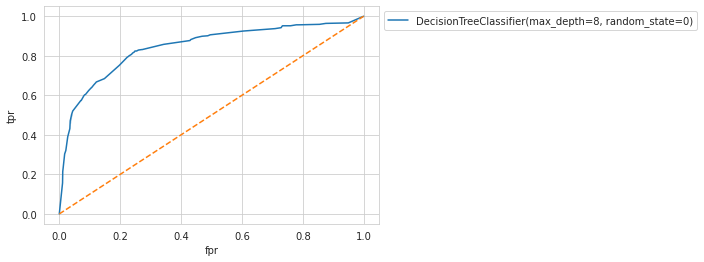

In [25]:
best_tree = find_best_model('tree', max_depth=100)
scores(best_tree)
roc_curve_draw([best_tree])

#### Случайный лес

f1-мера 0.65
ROC-AUC 0.87


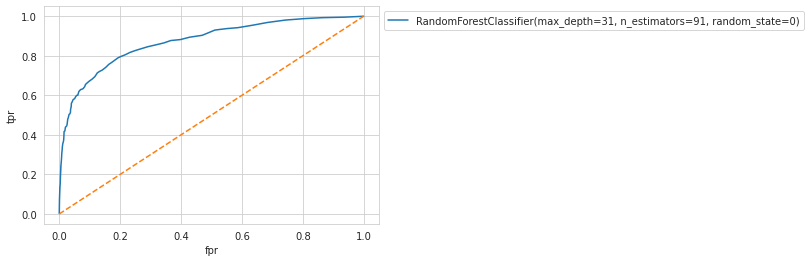

In [26]:
best_forest = find_best_model('forest', max_depth=100, n_estimators=100, step=10)
scores(best_forest)
roc_curve_draw([best_forest])

#### Логистическая регрессия

f1-мера 0.33
ROC-AUC 0.78


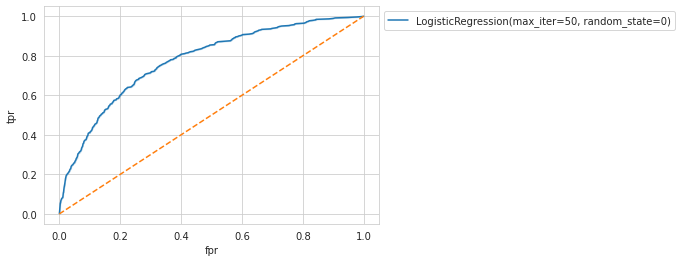

In [27]:
best_log_regression = find_best_model('logistic', max_iter=100, step=10)
scores(best_log_regression)
roc_curve_draw([best_log_regression])

*Вывод*: лучше всего на несбалансированных данных показала себя модель случайного леса.

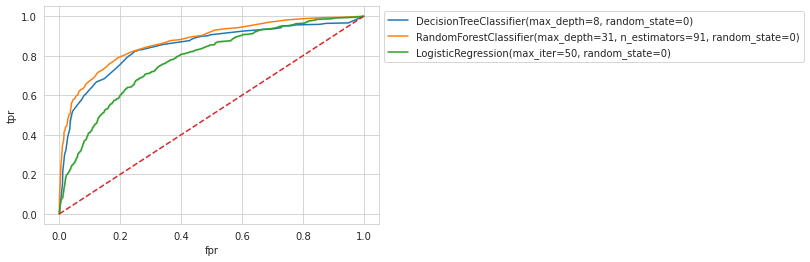

In [28]:
roc_curve_draw([best_tree, best_forest, best_log_regression])

## Борьба с дисбалансом

### Взвешивание классов

#### Дерево решений

f1-мера 0.59
ROC-AUC 0.82


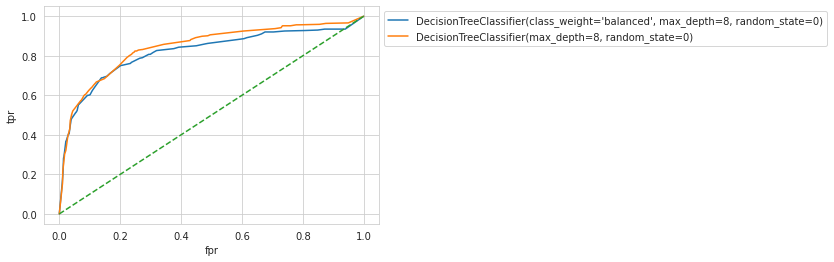

In [29]:
best_tree_balanced = find_best_model('tree', max_depth=100, class_weight='balanced')
scores(best_tree_balanced)
roc_curve_draw([best_tree_balanced, best_tree])

#### Случайный лес

f1-мера 0.64
ROC-AUC 0.88


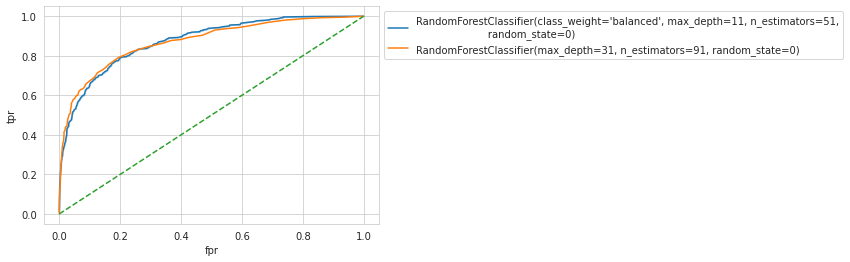

In [30]:
best_forest_balanced = find_best_model('forest', max_depth=100, n_estimators=100, step=10, class_weight='balanced')
scores(best_forest_balanced)
roc_curve_draw([best_forest_balanced, best_forest])

#### Логистическая регрессия

f1-мера 0.51
ROC-AUC 0.78


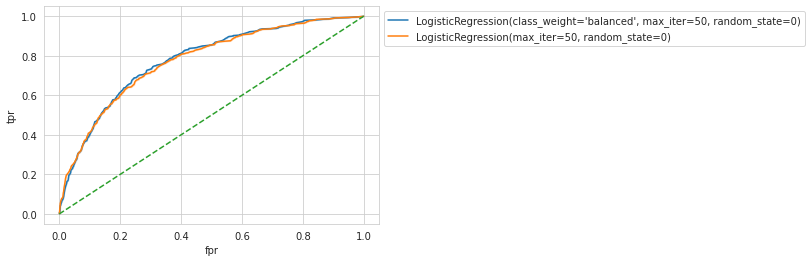

In [31]:
best_log_regression_balanced = find_best_model('logistic', max_iter=100, step=10, class_weight='balanced')
scores(best_log_regression_balanced)
roc_curve_draw([best_log_regression_balanced, best_log_regression])

*Вывод*: значительного прироста качества в моделях с балансированными классами не наблюдается.

### Увеличение выборки

In [22]:
features_train_upsampled, target_train_upsampled = shuffle(pd.concat([features_train[target_train == 0]] + [features_train[target_train == 1]]*4),
                                              pd.concat([target_train[target_train == 0]] + [target_train[target_train == 1]]*4),
                                              random_state=0)
target_train_upsampled.mean()

0.5035561877667141

#### Дерево решений

f1-мера 0.59
ROC-AUC 0.82


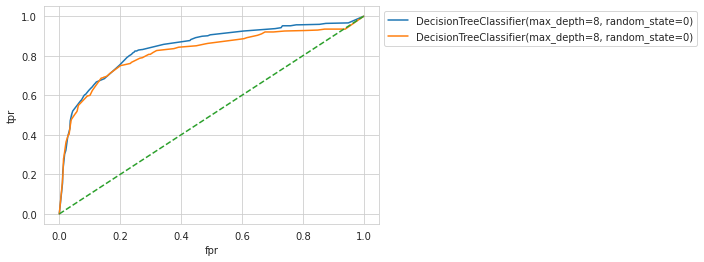

In [33]:
best_tree_upsampled = find_best_model(features_train=features_train_upsampled,
                                               target_train=target_train_upsampled,
                                               model='tree', max_depth=100)
scores(best_tree_upsampled)
roc_curve_draw([best_tree, best_tree_upsampled])

#### Случайный лес

f1-мера 0.65
ROC-AUC 0.88


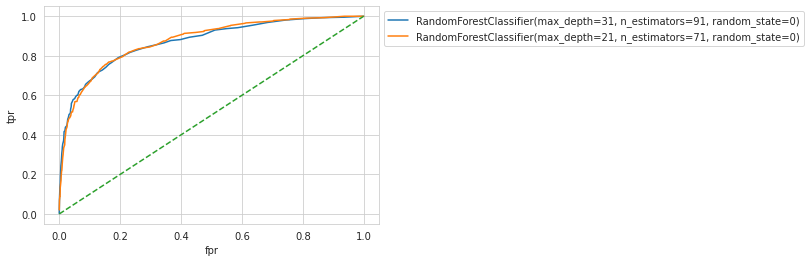

In [34]:
best_forest_upsampled = find_best_model(features_train=features_train_upsampled,
                                               target_train=target_train_upsampled,
                                               model='forest', max_depth=100, n_estimators=100, step=10)
scores(best_forest_upsampled)
roc_curve_draw([best_forest, best_forest_upsampled])

#### Логистическая регрессия

f1-мера 0.51
ROC-AUC 0.78


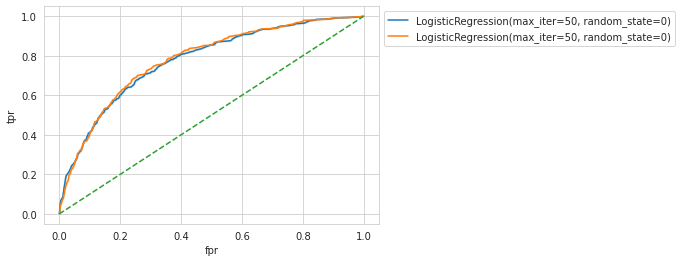

In [35]:
best_log_regression_upsampled = find_best_model(features_train=features_train_upsampled,
                                               target_train=target_train_upsampled,
                                               model='logistic', max_iter=100, step=10)
scores(best_log_regression_upsampled)
roc_curve_draw([best_log_regression, best_log_regression_upsampled])

*Вывод:* увеличение выборки не принесло начительно прироста качества моделей.

### Уменьшение выборки

In [23]:
(features_train_downsampled,
target_train_downsampled) = shuffle(
                                pd.concat([features_train[target_train == 0].sample(frac=0.25, random_state=0)] + [features_train[target_train == 1]]),
                                pd.concat([target_train[target_train == 0].sample(frac=0.25, random_state=0)] + [target_train[target_train == 1]]),
                                random_state=0)
target_train_downsampled.mean()

0.5035561877667141

#### Дерево решений

f1-мера 0.61
ROC-AUC 0.86


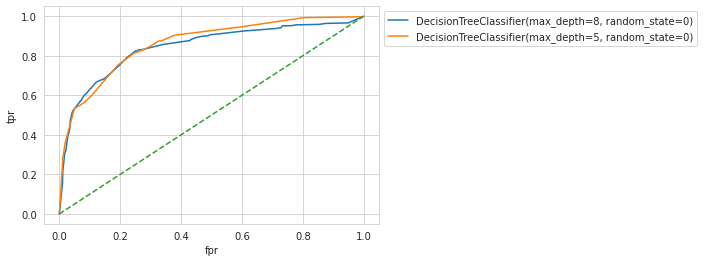

In [37]:
best_tree_downsampled = find_best_model(features_train=features_train_downsampled,
                                               target_train=target_train_downsampled,
                                               model='tree', max_depth=100)
scores(best_tree_downsampled)
roc_curve_draw([best_tree, best_tree_downsampled])

#### Случайный лес

f1-мера 0.62
ROC-AUC 0.87


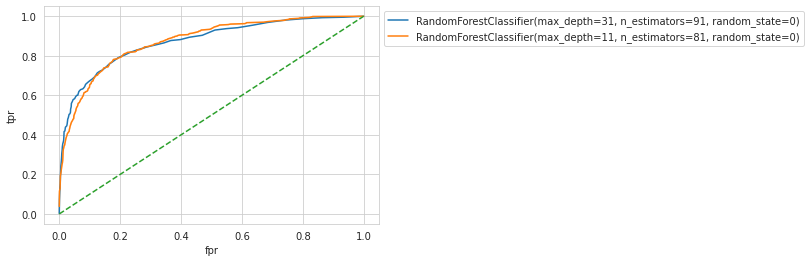

In [38]:
best_forest_downsampled = find_best_model(features_train=features_train_downsampled,
                                               target_train=target_train_downsampled,
                                               model='forest', max_depth=100, n_estimators=100, step=10)
scores(best_forest_downsampled)
roc_curve_draw([best_forest, best_forest_downsampled])

#### Логистическая регрессия

f1-мера 0.5
ROC-AUC 0.78


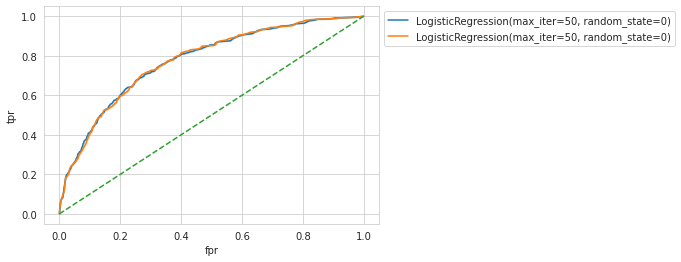

In [39]:
best_log_regression_downsampled = find_best_model(features_train=features_train_downsampled,
                                               target_train=target_train_downsampled,
                                               model='logistic', max_iter=100, step=10)
scores(best_log_regression_downsampled)
roc_curve_draw([best_log_regression, best_log_regression_downsampled])

*Вывод:* Уменьшение выборки позволило улучшить качетсво моделей незначительно.

## Тестирование модели

Посмотрим на качество модели случайного леса на тестовых данных, обученная на увеличенной выборкой.

In [42]:
scores(best_forest_upsampled, features=features_test, target=target_test)

f1-мера 0.6
ROC-AUC 0.85


На тествовой выборке модель ведет себя адекватно.

## Выводы

В результате исследования моделей дерева решений, случайного леса и логистической регрессии, обученных как на несбалансированных, так и на сбалансированных данных методами взвешивания весов, повышения и понижения размерности обучающих выборок, было выявлено, что наилучшим качеством обладает модель случайного леса с глубиной 31 и количеством деревьев 91, которая обучалась на увеличенной выборке. f1-мера такой модели на тестовой выборке достигла 0.6, а площадь под кривой ROC составила 0.85.